## 仅仅替换眼鼻口
参考博客：https://matthewearl.github.io/2015/07/28/switching-eds-with-python/

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cas = cv2.CascadeClassifier('./model/haarcascade_frontalface_alt2.xml')
obj = cv2.face.createFacemarkLBF()
obj.loadModel('./model/lbfmodel.yaml')

In [3]:
def detect_facepoint(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print(img_gray.shape)
    print(cas.detectMultiScale(img_gray,2,3,0,(30,30)))
    faces = cas.detectMultiScale(img_gray,2,3,0,(30,30))
    landmarks = obj.fit(img_gray,faces)
    assert landmarks[0],'no face detected'
    if(len(landmarks[1])>1):
        print('multi face detected,use the first')
    return faces[0],np.squeeze(landmarks[1][0])

In [4]:
def draw_kps(img,face_box,kps):
    img_show = img.copy()
    cv2.rectangle(img_show,(face_box[0],face_box[1]),(face_box[0]+face_box[2],face_box[1]+face_box[3]),(0,255,0),3)
    for i in range(kps.shape[0]):
        cv2.circle(img_show,(kps[i,0],kps[i,1]),2,(0,255,0),-1)
    img_show = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
    return img_show

## 第一种对齐方法
把第二张图片对齐到第一张图片

In [5]:
def transformation_from_points(points1, points2):
    points1 = points1.copy()
    points2 = points2.copy()
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    
    U, S, Vt = np.linalg.svd(np.dot(points1.T , points2))
    R = (np.dot(U , Vt)).T 
    return np.vstack([np.hstack(((s2 / s1) * R,
                                       np.array([c2.T - np.dot((s2 / s1) * R , c1.T)]).T )),
                         np.array([0., 0., 1.])])

In [6]:
def wrap_im(im,M,dshape):
    output_im = np.zeros(dshape,dtype=im.dtype)
    cv2.warpAffine(im,M[:2],(dshape[1],dshape[0]),dst=output_im,borderMode=cv2.BORDER_TRANSPARENT,flags=cv2.WARP_INVERSE_MAP)
    return output_im

In [7]:
def align_img1(img1,img2,landmarks1,landmarks2):
    trans_mat = transformation_from_points(landmarks1, landmarks2)
    img2_align = wrap_im(img2,trans_mat,img1.shape)
    return img2_align

## 第二种对齐方法
把第二张图片对齐到第一张图片

In [8]:
def align_img2(img1,img2,landmarks1,landmarks2):
    trans_mat,mask = cv2.findHomography(landmarks2, landmarks1, cv2.RANSAC,5.0)
    img2_align = cv2.warpPerspective(img2.copy(),trans_mat,(img1.shape[1],img1.shape[0]))
    return img2_align

## 颜色校正

In [9]:
COLOUR_CORRECT_BLUR_FRAC = 0.6
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)
    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(np.float64) * im1_blur.astype(np.float64) /im2_blur.astype(np.float64))

## 测试

(540, 540)
[[173 146 160 160]]
(889, 500)
[[178 138 160 160]]


(-0.5, 499.5, 888.5, -0.5)

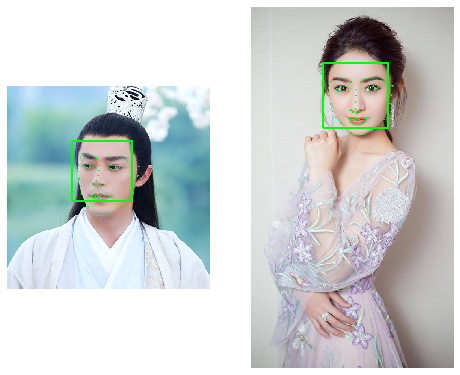

In [10]:
img1 = cv2.imread('./images/hjh.jpg')
img2 = cv2.imread('./images/zly.jpg')
face_box1,face_kps1 = detect_facepoint(img1)
face_kps1=face_kps1.astype(int)
face_box2,face_kps2 = detect_facepoint(img2)
face_kps2=face_kps2.astype(int)
plt.figure(figsize=[8,8])
plt.subplot(121)
plt.imshow(draw_kps(img1,face_box1,face_kps1))
plt.axis('off')
plt.subplot(122)
plt.imshow(draw_kps(img2,face_box2,face_kps2))
plt.axis('off')

(-0.5, 539.5, 539.5, -0.5)

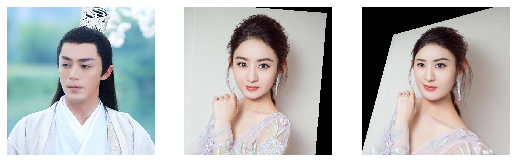

In [11]:
img2_align = align_img1(img1,img2,face_kps1,face_kps2)
plt.figure(figsize=[9,9])
plt.subplot(131)
plt.imshow(cv2.cvtColor(img1.copy(),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(132)
plt.imshow(cv2.cvtColor(img2_align.copy(),cv2.COLOR_BGR2RGB))
plt.axis('off')
img2_align2 = align_img2(img1,img2,face_kps1,face_kps2)
plt.subplot(133)
plt.imshow(cv2.cvtColor(img2_align2.copy(),cv2.COLOR_BGR2RGB))
plt.axis('off')

## 只贴眼鼻口

In [12]:
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_BROW_POINTS = list(range(17, 22))
NOSE_POINTS = list(range(27, 35))
MOUTH_POINTS = list(range(48, 61))
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]
FEATHER_AMOUNT = 11

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = np.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

In [13]:
img2_correct = correct_colours(img1,img2_align,face_kps1)

In [14]:
cv2.imwrite('img2_correct.png',img2_correct.copy().astype('uint8'))

True

(-0.5, 539.5, 539.5, -0.5)

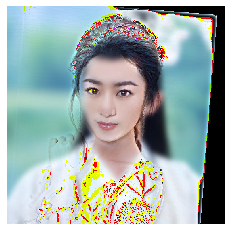

In [15]:
plt.imshow(cv2.cvtColor(img2_correct.copy().astype('uint8'),cv2.COLOR_BGR2RGB))
plt.axis('off')

In [16]:
mask = get_face_mask(img2, face_kps2)
warped_mask = align_img1(img1, mask,face_kps1,face_kps2)
combined_mask = np.max([get_face_mask(img1, face_kps1), warped_mask],
                          axis=0)

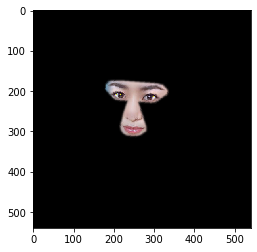

In [17]:
plt.imshow(np.multiply(img2_correct,combined_mask).astype('uint8')[...,::-1])

In [18]:
output_im = img1 * (1.0 - combined_mask) + img2_align * combined_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 539.5, 539.5, -0.5)

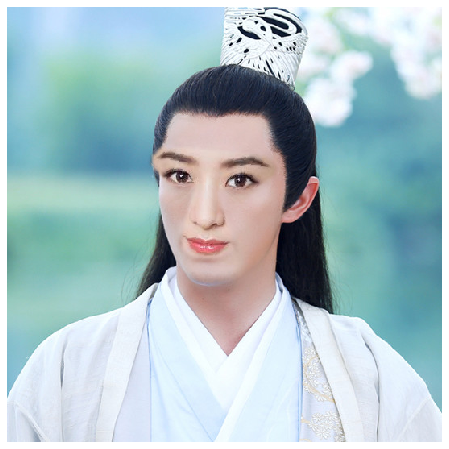

In [19]:
plt.figure(figsize=[8,8])
plt.imshow(output_im[...,::-1]/255)
plt.axis('off')

In [20]:
output_im = img1 * (1.0 - combined_mask) + img2_correct * combined_mask

In [21]:
cv2.imwrite('output.png',output_im)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 539.5, 539.5, -0.5)

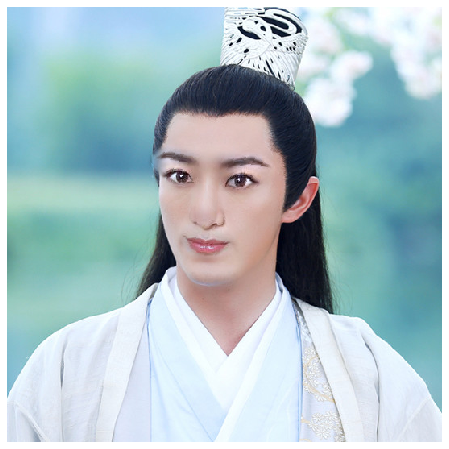

In [22]:
plt.figure(figsize=[8,8])
plt.imshow(output_im[...,::-1]/255)
plt.axis('off')